In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from itertools import combinations
import functools
import operator

In [2]:
df = pd.read_csv('yahoo-ETH-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-31,8.151150,8.158560,7.909380,7.969100,7.969100,9.066800e+06
2017-01-01,7.982310,8.471230,7.982310,8.172570,8.172570,1.473170e+07
2017-01-02,8.170870,8.436330,8.054410,8.378510,8.378510,1.457960e+07
2017-01-03,8.374580,9.996800,8.317170,9.725250,9.725250,3.362520e+07
2017-01-04,9.709290,11.276400,9.559810,11.251600,11.251600,4.105120e+07
...,...,...,...,...,...,...
2021-05-03,2951.175781,3450.037842,2951.175781,3431.086182,3431.086182,4.917429e+10
2021-05-04,3431.131592,3523.585938,3180.742676,3253.629395,3253.629395,6.240205e+10
2021-05-05,3240.554688,3541.462646,3213.101563,3522.783203,3522.783203,4.833420e+10


<AxesSubplot:xlabel='Date'>

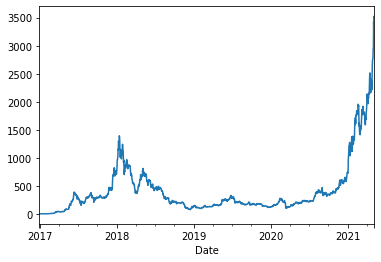

In [3]:
df['Open'].plot()

In [4]:
def get_ongoing_bubble(d):
    return d['2021-04':].copy()

def get_past_bubble_burst(d):
    return d['2018-01':'2018-08'].copy()

In [5]:
# testing pandas library diff behavior
s = pd.Series([1, 1, 2, 3, 5, 8])
print(s.diff(periods=1)) # change from previous datapoint
print(s.diff(periods=-1)*-1) # change of next datapoint
s = pd.Series([1, 2, 3, 4, 5, 6])
print(s.diff(periods=-2)*-1)

0    NaN
1    0.0
2    1.0
3    1.0
4    2.0
5    3.0
dtype: float64
0   -0.0
1    1.0
2    1.0
3    2.0
4    3.0
5    NaN
dtype: float64
0    2.0
1    2.0
2    2.0
3    2.0
4    NaN
5    NaN
dtype: float64


<AxesSubplot:xlabel='Date'>

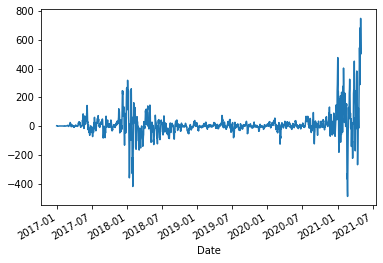

In [6]:
# calculate gains of selling x days later at any day
key_gain = lambda x: f"Close_gain_after_{x}"
key_gain_pct = lambda x: f"Close_pct_gain_after_{x}"
    
def calculate_x_day_gain_at_close(d, x):
    gain = d['Close'].diff(-1 * x) * -1
    pct_gain = 100*gain/d['Close']
    new_d = d.join(gain, rsuffix=key_gain(x)[5:]).join(pct_gain, rsuffix=key_gain_pct(x)[5:])
    return new_d[new_d[key_gain(x)].notnull()].copy()
    #return new_d

def april_dumb_strats_test(x):
    df_x_april = get_ongoing_bubble(calculate_x_day_gain_at_close(df, x))
    df_x_april[key_gain(x)].plot()
    print(f"dumb strat: buy and hold for {x} days during apr 2021")
    print(f"times won: {np.count_nonzero((df_x_april[key_gain(x)]>0).values)}/{df_x_april.shape[0]}")
    print(f"avg pct return: {df_x_april[key_gain_pct(x)].mean()}")

def bubble_burst_dumb_strats_test(x):
    df_bubble = get_past_bubble_burst(calculate_x_day_gain_at_close(df, x))
    df_bubble[key_gain(x)].plot()
    print(f"dumb strat: buy and hold for {x} days during jan-june 2018")
    print(f"times won: {np.count_nonzero((df_bubble[key_gain(x)]>0).values)}/{df_bubble.shape[0]}")
    print(f"avg pct return: {df_bubble[key_gain_pct(x)].mean()}")

calculate_x_day_gain_at_close(df, 5)[key_gain(5)].plot()

dumb strat: buy and hold for 5 days during apr 2021
times won: 25/32
avg pct return: 8.676586511078863


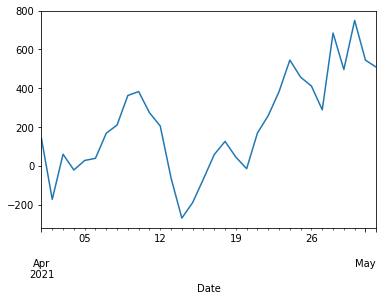

In [7]:
april_dumb_strats_test(5)

dumb strat: buy and hold for 7 days during apr 2021
times won: 25/30
avg pct return: 12.10769381436009


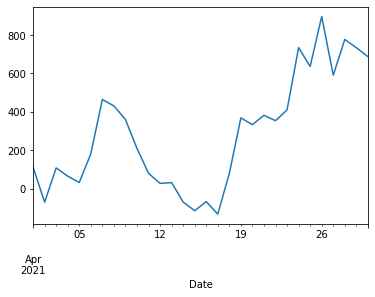

In [8]:
april_dumb_strats_test(7)

dumb strat: buy and hold for 14 days during apr 2021
times won: 23/23
avg pct return: 21.865628208537114


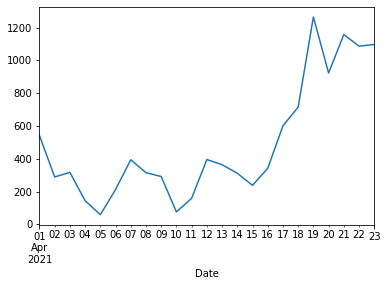

In [9]:
april_dumb_strats_test(14)

dumb strat: buy and hold for 5 days during jan-june 2018
times won: 106/243
avg pct return: -1.6425235690215567


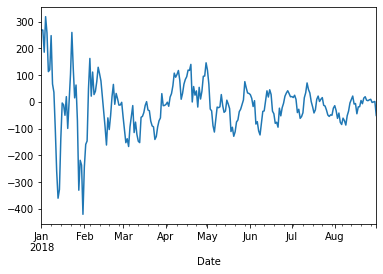

In [10]:
bubble_burst_dumb_strats_test(5)

dumb strat: buy and hold for 14 days during jan-june 2018
times won: 78/243
avg pct return: -6.580751920759351


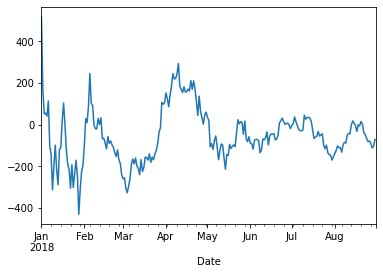

In [11]:
bubble_burst_dumb_strats_test(14)

In [12]:
key_price_change = "Open_change"
key_price_change_pct = "Open_pct_change"
key_vol_change = "Volume_change"
key_vol_change_pct = "Volume_pct_change"

# plain change is estimate for a in f(t)=at+b, pct change is estimate for 100*b in f(t)=a(1+b)^t
def calculate_changes(d):
    price_change = d['Open'].diff(1)
    pct_price_change = 100*price_change/d['Open']
    vol_change = df['Volume'].diff(1)
    pct_vol_change = vol_change/df['Volume']
    new_d = d.join(price_change, rsuffix=key_price_change[4:])\
        .join(pct_price_change, rsuffix=key_price_change_pct[4:])\
        .join(vol_change, rsuffix=key_vol_change[6:])\
        .join(pct_vol_change, rsuffix=key_vol_change_pct[6:])
    return new_d[new_d[key_price_change].notnull()].copy()

# includes gains for holding 5 days
df_augmented = calculate_x_day_gain_at_close(df, 5)
# includes extra information
df_augmented = calculate_changes(df_augmented)
df_augmented

,Open,High,Low,Close,Adj Close,Volume,Close_gain_after_5,Close_pct_gain_after_5,Open_change,Open_pct_change,Volume_change,Volume_pct_change
Date,,,,,,,,,,,,
2017-01-01,7.982310,8.471230,7.982310,8.172570,8.172570,1.473170e+07,2.082130,25.477053,-0.168840,-2.115177,5.664900e+06,0.384538
2017-01-02,8.170870,8.436330,8.054410,8.378510,8.378510,1.457960e+07,1.488680,17.767837,0.188560,2.307710,-1.521000e+05,-0.010432
2017-01-03,8.374580,9.996800,8.317170,9.725250,9.725250,3.362520e+07,0.564550,5.804992,0.203710,2.432480,1.904560e+07,0.566409
2017-01-04,9.709290,11.276400,9.559810,11.251600,11.251600,4.105120e+07,-0.926000,-8.229941,1.334710,13.746731,7.426000e+06,0.180896
2017-01-05,11.286800,11.890900,9.402680,10.254400,10.254400,4.155740e+07,0.295200,2.878764,1.577510,13.976592,5.062000e+05,0.012181
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28,2664.685547,2757.477295,2564.081543,2746.380127,2746.380127,3.426903e+10,684.706055,24.931219,130.654297,4.903179,1.993062e+09,0.058159
2021-04-29,2748.649658,2797.972412,2672.106689,2756.876953,2756.876953,3.257813e+10,496.752442,18.018666,83.964111,3.054740,-1.690903e+09,-0.051903
2021-04-30,2757.734131,2796.054932,2728.169922,2773.207031,2773.207031,2.977718e+10,749.576172,27.029218,9.084473,0.329418,-2.800948e+09,-0.094064


In [13]:
df_augmented_current = get_ongoing_bubble(df_augmented)
df_augmented_past = get_past_bubble_burst(df_augmented)
values_of_interest = {"Open", "Open_change", "Open_pct_change", "Volume", "Volume_change", "Volume_pct_change", "Close_gain_after_5",
                    "Close_pct_gain_after_5"}

In [14]:
variables = {"Open", "Open_change", "Open_pct_change", "Volume", "Volume_change", "Volume_pct_change"}

def generate_formula(order):
    combs = functools.reduce(operator.iconcat,map(lambda i: list(combinations(variables, i)), range(1,order+1)),[])
    return functools.reduce(lambda x,y:x+'+'+y, map(lambda l:functools.reduce(lambda x,y:x+'*'+y,l), combs))

In [15]:
# gain of course correlated with open
# tons of highly correlated variable interactions

form = f"Close_gain_after_5~{generate_formula(6)}"
mod = smf.ols(formula=form, data=df_augmented).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Close_gain_after_5   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     14.64
Date:                Fri, 07 May 2021   Prob (F-statistic):           1.67e-49
Time:                        09:26:26   Log-Likelihood:                -9028.6
No. Observations:                1572   AIC:                         1.810e+04
Df Residuals:                    1549   BIC:                         1.823e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               -2.906e-14   2.43e-14     -1.198      0.231   -7.66e-14    1.85e-14
Volume                                                                   1.893e-14   4.22e-14      0.449      0.654   -6.38e-14    1.02e-13
Open_change                                                             -1.052e-13   6.64e-14     -1.585      0.113   -2.35e-13     2.5e-14
Open                                                                      3.63e-15   4.02e-15      0.903      0.367   -4.25e-15    1.15e-14
Volume_pct_change                                                        9.643e-16   1.15e-15      0.842      0.400   -1.28e-15    3.21e-15
Open_pct_change                                                          5.262e-17    9.6e-17      0.548      0.584   -1.36e-16    2.41e-16
Volume_change                                                           -3.861e-15   6.57e-15     -0.588      0.557   -1.67e-14    9.02e-15
Volume:Open_change                                                      -3.406e-15   9.53e-16     -3.574      0.000   -5.27e-15   -1.54e-15
Volume:Open                                                              1.867e-12   1.81e-13     10.318      0.000    1.51e-12    2.22e-12
Volume:Volume_pct_change                                                -3.626e-15   6.52e-15     -0.556      0.578   -1.64e-14    9.17e-15
Volume:Open_pct_change                                                  -2.704e-14   1.74e-14     -1.554      0.120   -6.12e-14     7.1e-15
Volume:Volume_change                                                    -5.544e-21   7.45e-20     -0.074      0.941   -1.52e-19    1.41e-19
Open_change:Open                                                        -1.087e-19   9.29e-20     -1.170      0.242   -2.91e-19    7.36e-20
Open_change:Volume_pct_change                                             7.16e-20   4.89e-20      1.464      0.143   -2.43e-20    1.68e-19
Open_change:Open_pct_change                                             -1.191e-20   7.62e-21     -1.563      0.118   -2.69e-20    3.04e-21
Open_change:Volume_change                                                7.384e-15   7.19e-15      1.028      0.304   -6.71e-15    2.15e-14
Open:Volume_pct_change                                                   2.426e-22   7.55e-22      0.321      0.748   -1.24e-21    1.72e-21
Open:Open_pct_change                                                     9.926e-21   4.82e-21      2.060      0.040    4.72e-22    1.94e-20
Open:Volume_change                                                      -1.942e-12    1.6e-12     -1.216      0.224   -5.07e-12    1.19e-12
Vol

In [16]:
# gain pct appears to only be correlated with volume*open, maybe vol*vol_change*vol_pct_change
# harder to predict - not interested
# negative r2 for some reason - shitty bugged library

# form_pct = f"Close_pct_gain_after_5~{generate_formula(6)}"
# pct_mod = smf.ols(formula=form_pct, data=df_augmented).fit()
# pct_mod.summary()

In [17]:
p_vals = (pd.read_html(mod.summary().tables[1].as_html(), header=0,index_col=0)[0])['P>|t|']
#p_vals.to_csv('pvals.csv')
#p_vals = pd.read_csv("pvals.csv", index_col="Unnamed: 0")['P>|t|']
p_vals.sort_values().head(40)

Volume:Open_change:Open:Volume_pct_change:Open_pct_change:Volume_change    0.000
Volume:Open:Open_pct_change                                                0.000
Volume:Open_change:Volume_pct_change:Open_pct_change:Volume_change         0.000
Volume:Open_change                                                         0.000
Volume:Open                                                                0.000
Volume:Open_change:Open_pct_change                                         0.001
Volume:Open_change:Open                                                    0.001
Volume:Volume_pct_change:Open_pct_change:Volume_change                     0.002
Volume:Open_change:Open:Volume_pct_change                                  0.002
Open_change:Open:Volume_change                                             0.002
Open_change:Open:Volume_pct_change:Volume_change                           0.008
Open_change:Volume_pct_change:Volume_change                                0.012
Volume:Open_change:Open:Open

In [21]:
# new model with fewer variables
# interests = p_vals[p_vals.sort_values()<0.15].index
# new_vars = list(map(lambda s:functools.reduce(lambda x,y:x+'*'+y,s.split(':')), interests))
# print(len(new_vars))
# new_formula = functools.reduce(lambda x,y:x+'+'+y,new_vars)
# new_mod = smf.ols(f"Close_gain_after_5~{new_formula}", data=df_augmented).fit()
# new_mod.summary()

In [25]:
# new model with fewer variables
# have to do this shit cuz statsmodels cant handle interaction formulas property
interests = p_vals[p_vals.sort_values()<0.1].index
keys = []
for interest in interests:
    variables = interest.split(':')
    interaction_name = functools.reduce(lambda x,y:x+'And'+y,variables)
    keys.append(interaction_name)
    result = df_augmented[variables[0]]
    for var in variables[1:]:
        result = result*df_augmented[var]
    df_augmented[interaction_name] = result
    
new_formula = functools.reduce(lambda x,y:x+'+'+y,keys)
new_mod = smf.ols(f"Close_gain_after_5~{new_formula}", data=df_augmented).fit()
new_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Close_gain_after_5   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     23.26
Date:                Fri, 07 May 2021   Prob (F-statistic):           3.60e-48
Time:                        09:29:10   Log-Likelihood:                -9047.6
No. Observations:                1572   AIC:                         1.812e+04
Df Residuals:                    1559   BIC:                         1.819e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                         -9.825e-26   3.03e-26     -3.239      0.001   -1.58e-25   -3.87e-26
VolumeAndOpen_change                                                              -7.478e-16   8.86e-16     -0.844      0.399   -2.49e-15     9.9e-16
VolumeAndOpen                                                                      1.601e-12   1.46e-13     10.946      0.000    1.31e-12    1.89e-12
OpenAndOpen_pct_change                                                             1.163e-18   2.69e-19      4.328      0.000    6.36e-19    1.69e-18
Volume_pct_changeAndOpen_pct_change                                               -3.227e-20   7.43e-21     -4.342      0.000   -4.68e-20   -1.77e-20
VolumeAndOpen_changeAndOpen                                                        1.139e-14   4.95e-15      2.304      0.021    1.69e-15    2.11e-14
VolumeAndOpen_changeAndOpen_pct_change                                            -2.321e-12   5.68e-13     -4.083      0.000   -3.44e-12   -1.21e-12
VolumeAndOpenAndOpen_pct_change                                                   -1.918e-13   8.36e-14     -2.293      0.022   -3.56e-13   -2.77e-14
Open_changeAndOpenAndVolume_change                                                -1.052e-13   1.88e-14     -5.595      0.000   -1.42e-13   -6.83e-14
Open_changeAndVolume_pct_changeAndVolume_change                                    5.495e-14   1.38e-14      3.977      0.000    2.78e-14     8.2e-14
Volume_pct_changeAndOpen_pct_changeAndVolume_change                                8.691e-15   2.05e-15      4.234      0.000    4.66e-15    1.27e-14
VolumeAndOpen_changeAndOpenAndVolume_pct_change                                   -1.052e-13   1.88e-14     -5.595      0.000   -1.42e-13   -6.83e-14
VolumeAndOpen_changeAndOpenAndOpen_pct_change                                      1.641e-15   5.02e-16      3.270      0.001    6.57e-16    2.63e-15
VolumeAndOpen_changeAndOpenAndVolume_change                                        5.611e-24   9.52e-25      5.896      0.000    3.74e-24    7.48e-24
VolumeAndVolume_pct_changeAndOpen_pct_changeAndVolume_change                      -2.144e-20    2.1e-20     -1.020      0.308   -6.27e-20    1.98e-20
Open_changeAndOpenAndVolume_pct_changeAndVolume_change                             -4.73e-13   7.47e-14     -6.335      0.000    -6.2e-13   -3.27e-13
OpenAndVolume_pct_changeAndOpen_pct_changeAndVolume_change                         5.495e-12   1.38e-12      3.977      0.000    2.78e-12     8.2e-12
VolumeAndOpen_changeAndVolume_pct_changeAndOpen_pct_changeAndVolume_change         

In [27]:
# fuck it im going to sleep
# just buying ethereum at market open
# although if i had more time i would develop a better strategy using the predictive power of volume